## Современные библиотеки градиентного бустинга

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* XGBoost. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
* LightGBM. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O$(#bins). Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Таким образом каждое дерево является цепочкой с прикрепленными листьями, поэтому ограничение на num_leaves получается более осмысленным.
* CatBoost. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки. Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

### Основные параметры

(lightgbm/catboost)

* objective – функционал, на который будет настраиваться композиция
* eta / learning_rate – темп (скорость) обучения
* num_iterations / n_estimators  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* max_depth – максимальная глубина 
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева 
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева 

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].




In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
! pip install lightgbm
! pip install --upgrade catboost==0.19.1

     |████████████████████████████████| 686kB 747kB/s eta 0:00:01
     |████████████████████████████████| 10.0MB 13.2MB/s eta 0:00:01
  Found existing installation: catboost 0.23
    Uninstalling catboost-0.23:
      Successfully uninstalled catboost-0.23


In [3]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

## Catboost

0.9096728307254623


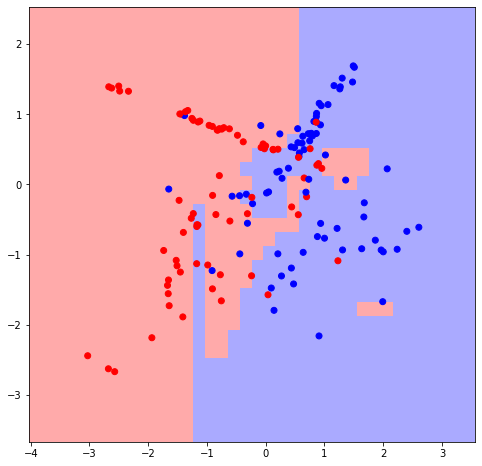

In [4]:
from catboost import CatBoostClassifier 

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

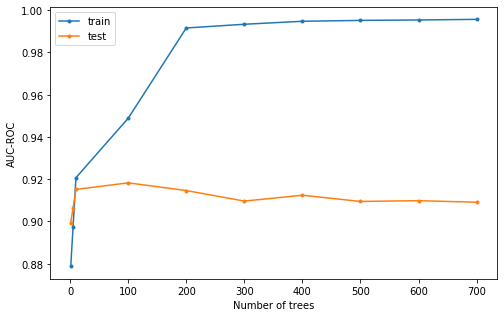

In [5]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

0.8629089615931721


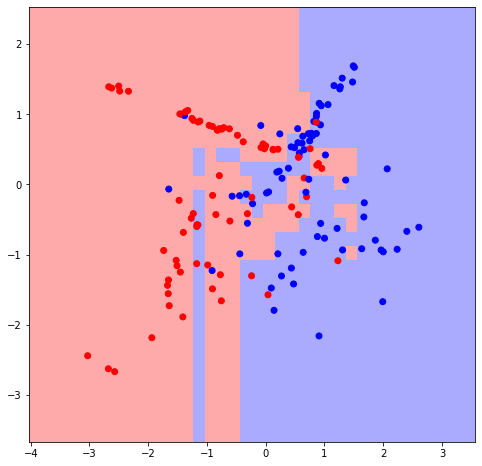

In [6]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

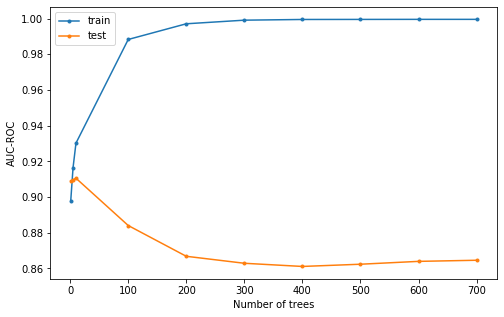

In [7]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь попробуем взять фиксированное количество деревьев, но будем менять из глубину

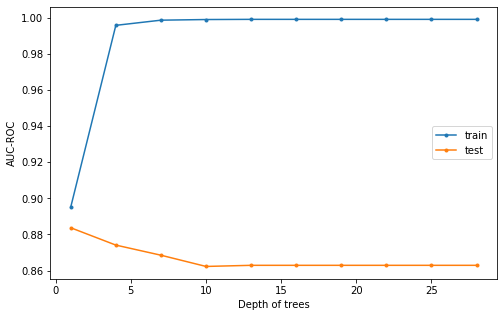

In [8]:
depth = list(range(1, 30, 3))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

И сравним с Catboost:

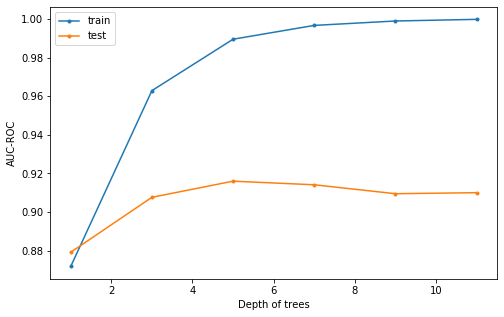

In [9]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь, когда у нас получились отличные модели, нужно их сохранить!

In [10]:
lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

И загрузим обратно, когда понадобится их применить

In [11]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

## Блендинг

Как было рассказано на лекции, блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов. Рассмотрим простой пример блендинга бустинга и линейной регрессии.

In [12]:
from sklearn.datasets import load_boston

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [13]:
from catboost import CatBoostRegressor

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 8.4515
Test RMSE GB = 10.1493


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


Для простоты будем считать, что новый алгоритм $a(x)$ представим как
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum_{n} w_n =1$

In [15]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [16]:
rmse_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), key=lambda x: x[0])

In [17]:
rmse_blending_train

4.409822847300099

In [18]:
rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

5.4149466026877535

В итоге получаем качество на тестовой выборке лучше, чем у каждого алгоритма в отдельности.

Полезные ссылки:

* [Видео про стекинг](https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6)
* [Продвинутый вариант стекинга с использованием нейросетей](https://www.coursera.org/learn/competitive-data-science/lecture/s8RLi/stacknet)

## Важность признаков

В курсе мы подробно обсуждаем, как добиваться хорошего качества решения задачи: имея выборку $X, y$, построить алгоритм с наименьшей ошибкой. Однако заказчику часто важно понимать, как работает алгоритм, почему он делает такие предсказания. Обсудим несколько мотиваций.
	
#### Доверие алгоритму
Например, а банках на основе решений, принятых алгоритмом, выполняются финансовые операции, и менеджер, ответственный за эти операции, будет готов использовать алгоритм, только если он понимает, что его решения обоснованы. По этой причине в банках очень часто используют простые линейные алгоритмы. Другой пример из области медицины: поскольку цена ошибки может быть очень велика, врачи готовы использовать только интерпретируемые алгоритмы.
	
#### Отсутствие дискриминации (fairness) 
Вновь пример с банком: алгоритм кредитного скоринга не должен учитывать расовую принадлежность (racial bias) заемщика или его пол (gender bias). Между тем, такие зависимости часто могут присутствовать в датасете (исторические данные), на котором обучался алгоритм.  Еще один пример: известно, что нейросетевые векторы слов содержат gender bias. Если эти вектора использовались при построении системы поиска по резюме для рекрутера, то например по запросу `technical skill` он будет видеть женские резюме в конце ранжированного списка.
	
#### Учет контекста
Данные, на которых обучается алгоритм, не отображают всю предметную область. Интерпретация алгоритма позволит оценить, насколько найденные зависимости связаны с реальной жизнью. Если предсказания интерпретируемы, это также говорит о высокой обобщающей способности алгоритма. 

Теперь обсудим несколько вариантов, как можно оценивать важность признаков.

### Веса линейной модели

Самый простой способ, который уже был рассмотрен на семинаре про линейные модели: после построения модели каждому признаку будет соответствовать свой вес - если признаки масштабированы, то чем он больше по модулю, тем важнее признак, а знак будет говорить о положительном или отрицательном влиянии на величину целевой переменной.

### FSTR

fstr говорит, что важность признака &mdash; это то, насколько в среднем меняется ответ модели при изменении значения данного признака (изменении значения разбиения).

Рассчитать его можно так:

$$feature\_importance_{F} = \sum_{tree, leaves_F} (v_1 - avr)^2\cdot c_1 +(v_2 - avr)^2\cdot c_2\\
\qquad avr = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}.$$

Запись $leaves_F$ выше означает разбиение, зависящее от признака $F$.

Мы сравниваем поддеревья, отличающиеся значением сплита в узле на пути к ним: если условие сплита выполняется, объект попадает в левое поддерево, иначе &mdash; в правое. 

$c_1, c_2 - $  число объектов обучающего датасета, попавших в левое и правое поддерево соотвественно, либо суммарный вес этих объектов, если используются веса; $v1, v2 -$значение модели в левом и правом поддереве.


Далее значения $feature\_importance$ нормируются, и получаются величины, которые суммируются в 100.

In [19]:
for val, name in sorted(zip(cbm.feature_importances_, data.feature_names))[::-1]:
    print(name, val)

NOX 14.49968557058814
CHAS 10.352276220633168
ZN 10.329963680671257
RAD 9.904830088754682
PTRATIO 9.237666537826932
B 7.6414859175453245
LSTAT 7.456955998396042
TAX 7.1879363932211735
DIS 6.311233677340058
INDUS 5.712132196221784
AGE 4.7002374670945315
RM 3.4603743319002764
CRIM 3.205221919806629


In [20]:
sum(cbm.feature_importances_)

99.99999999999999

### Out-of-bag

В случайном лесе за счет обучения на подвыборках можно использовать out-of-bag оценки - ошибка композиции $a(x) = \sum_{n=1}^N b_n(x)$, построенной с помощью бэггинга с базовыми алгоритмами $b_i(x)$, вычисляется по формуле (подробнее см. конспект лекции 8):
     $$
     \text{OOB} = \sum_{i=1}^\ell L\biggl(y_i, \frac 1 {\sum_{n=1}^N [x_i \notin X_n]} \sum_{n=1}^N [x_i \notin X_n] b_n(x_i)\biggr)
      $$     
Можно показать, что по мере увеличения числа деревьев 
данная оценка стремится к leave-one-out-оценке,
но при этом существенно проще для вычисления.
     
Итоговый алгоритм подсчета важностей для случайного леса выглядит так:
* Вычислить OOB для случайного леса, обученного по исходной обучающей выборке
*  Для каждого признака $j$:

    * Перемешать значения признака по всем объектам обучающей выборки &mdash; мы хотим сделать признак неинформативным
    * Вычислить OOB$_j$ случайного леса, обученного по измененной обучающей выборке
    * Оценить важности: $R_j = \max(0, \text{OOB}-\text{OOB}_j)$

Приведем простейший пример, как можно получить такую оценку в sklearn-реализации RandomForest

In [21]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, oob_score=True)
clf.fit(X_train, y_train)

clf.oob_score_

0.8533542301610743

## Интерпретация алгоритмов

Отдельным направлением исследований является анализ уже построенных алгоритмов. Разберем наиболее популярный метод &mdash; LIME. 
   
   Предположим, что мы обучили алгоритм $a$ на выборке {$X, y$}, и хотим интерпретировать его предсказания. Алгоритм LIME выполняет локальную интерпретацию, то есть объясняет предсказания для конкретного объекта. Основная идея состоит в локальном приближении разделяющей поверхности алгоритма другим, более простым алгоритмом $b$ (например, линейным). Итак, чтобы объяснить предсказания $a(x)$ на конкретном объекте $x$:
   
* Сгенерировать выборку точек $x_1, \dots, x_m$ около объекта $x$.
* Обучить интерпретируемый алгоритм $b$ на выборке $\{(x_1, a(x_1)), \dots, (x_m, a(x_m))\}$.
* Интерпретировать алгоритм $b$.

   Если мы приближаем разделяющую поверхность линейной функцией $b$, то по обученным весам можно сказать, какой вклад вносит каждый признак в предсказания в окрестности точки $x$.

## XGBoost

In [22]:
# based on https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import learning_curve, GridSearchCV  #Perforing grid search
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.datasets import load_breast_cancer, fetch_lfw_pairs, make_classification
rcParams['figure.figsize'] = 12, 4

In [89]:
titanic = pd.read_csv('./titanic.csv')

In [91]:
X = titanic[['Pclass', 'Age', 'SibSp', 'Fare']]
y = titanic.Survived.values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 4), (712,), (179, 4), (179,))

In [95]:
def modelfit(alg, dtrain, y, X_test=None, y_test=None, test=True, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy (Train): %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    if test:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:,1]
        print ("Accuracy (Test): %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
        print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    # return alg              
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [96]:
#Choose all predictors except target & IDcols
# predictors = [x for x in X.columns]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 booster='gbtree',
 seed=27)


Model Report
Accuracy (Train): 0.7598
AUC Score (Train): 0.844032
Accuracy (Test): 0.7207
AUC Score (Test): 0.790026


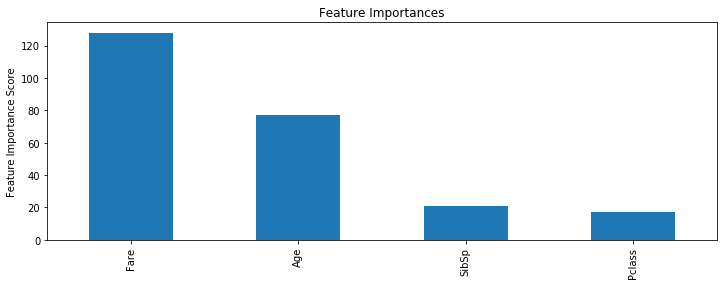

In [97]:
modelfit(xgb1, X_train, y_train, X_test, y_test)

In [98]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.0476541 , 0.04777527, 0.04843454, 0.06391163, 0.0639379 ,
         0.06255479, 0.07947907, 0.07803788, 0.06982574, 0.09433928,
         0.07819257, 0.05911288]),
  'std_fit_time': array([0.00130447, 0.00146977, 0.00213002, 0.00225058, 0.00156319,
         0.00360464, 0.00280012, 0.0048545 , 0.00245415, 0.00296998,
         0.00211354, 0.00627496]),
  'mean_score_time': array([0.00324826, 0.00268674, 0.00264421, 0.00335526, 0.00306935,
         0.00361867, 0.00370908, 0.00343351, 0.00316763, 0.00375204,
         0.00337529, 0.00406246]),
  'std_score_time': array([2.52618291e-04, 4.99018686e-05, 1.99016544e-05, 5.39413318e-04,
         1.21639280e-05, 1.29439020e-03, 2.36478398e-04, 1.47232026e-04,
         1.12571346e-04, 1.31683051e-05, 5.38684607e-05, 2.74984127e-03]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, F

In [99]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[4, 5, 6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.09344988, 0.08831086, 0.081534  , 0.09135327, 0.09193645,
         0.09216018, 0.10480437, 0.09053612, 0.05721316]),
  'std_fit_time': array([0.01378722, 0.00967569, 0.00683263, 0.00736975, 0.01085198,
         0.0058659 , 0.00747509, 0.00896845, 0.01129121]),
  'mean_score_time': array([0.00602403, 0.00338836, 0.0037468 , 0.00519094, 0.00393815,
         0.0061832 , 0.00377998, 0.00441604, 0.00253458]),
  'std_score_time': array([0.00249067, 0.00010394, 0.00083963, 0.00291683, 0.00066816,
         0.00289762, 0.0006696 , 0.00205431, 0.00029978]),
  'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
      

In [100]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.08651114, 0.08192577, 0.06643147, 0.06674929, 0.0642797 ]),
  'std_fit_time': array([0.0100525 , 0.01140936, 0.00136921, 0.00109331, 0.0071481 ]),
  'mean_score_time': array([0.00755658, 0.00321445, 0.00373211, 0.00286555, 0.00270376]),
  'std_score_time': array([0.00329903, 0.00013102, 0.00139628, 0.00025287, 0.00039247]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.69725343, 0.69725343, 0.69538077, 0.69434041, 0.6920516 ]),
  'split1_test_score': array([0.73553891, 0.74469413, 0.73595506, 0.73012901, 0.73116937]),
  'split2_test_score': array([0.76552894, 0.75280899, 0.76256095, 0.76531694, 0.76531694]),
  'split3_test_score': array([0.71168115, 0.70903116, 0.70786517, 0.70616918, 0.71252915]),


Model Report
Accuracy (Train): 0.75
AUC Score (Train): 0.817517
Accuracy (Test): 0.7318
AUC Score (Test): 0.789189


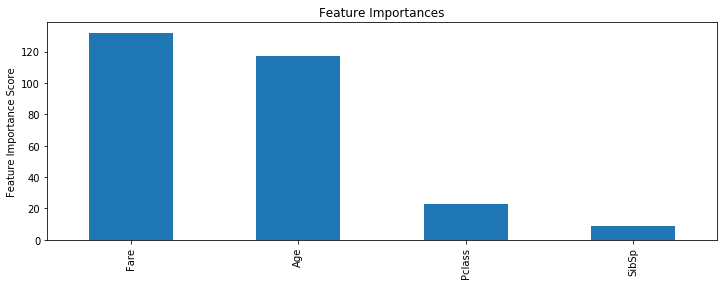

In [101]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 booster='gbtree',
 seed=27)
modelfit(xgb2, X_train, y_train, X_test, y_test)

In [102]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.08402209, 0.0903821 , 0.07046685, 0.07186708, 0.06538901,
         0.08886108, 0.08840098, 0.08704467, 0.08473682, 0.08697238,
         0.08924866, 0.10120502, 0.0854528 , 0.10375571, 0.083109  ,
         0.06669312]),
  'std_fit_time': array([0.01217588, 0.01862759, 0.00292809, 0.00300116, 0.00486138,
         0.01361887, 0.01338767, 0.01427338, 0.00798576, 0.00568783,
         0.0080008 , 0.01042552, 0.00724199, 0.01317843, 0.02512189,
         0.01826749]),
  'mean_score_time': array([0.00814176, 0.00342789, 0.00352235, 0.00368423, 0.00320625,
         0.00547552, 0.00357146, 0.00493331, 0.00422077, 0.00371385,
         0.00348892, 0.0040525 , 0.00375504, 0.0036026 , 0.00456638,
         0.00281806]),
  'std_score_time': array([0.00479212, 0.00021692, 0.00052315, 0.00037011, 0.00014089,
         0.00136127, 0.0002299 , 0.00214189, 0.00145867, 0.00062746,
         0.00030715, 0.00077096, 0.00061822, 0.00089642, 0.00324715,
         0.0004652 ]),
  'param_c

In [105]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55, 70, 5)],
 'colsample_bytree':[i/100.0 for i in range(55, 70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.07866907, 0.08172641, 0.06625009, 0.06328635, 0.06678243,
         0.08969131, 0.09237061, 0.09715362, 0.05110173]),
  'std_fit_time': array([0.00930357, 0.01000227, 0.00346659, 0.00292522, 0.00407635,
         0.02937216, 0.02194809, 0.02273177, 0.00678978]),
  'mean_score_time': array([0.00488734, 0.00340362, 0.00314312, 0.00333929, 0.00314879,
         0.00474386, 0.00373788, 0.00671759, 0.00293446]),
  'std_score_time': array([1.58899792e-03, 3.27001295e-04, 2.66267338e-05, 4.24543496e-04,
         1.06452974e-04, 2.13833510e-03, 3.60287359e-04, 4.17066655e-03,
         2.25626525e-04]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.55, 0.6, 0.65, 0.55, 0.6, 0.65, 0.55, 0.6, 0.65],
               mask=[F

In [106]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.6, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.08330884, 0.07656627, 0.06497135, 0.06324677, 0.0361588 ]),
  'std_fit_time': array([0.01516454, 0.01290403, 0.00266374, 0.00332178, 0.00252051]),
  'mean_score_time': array([0.00766044, 0.00406375, 0.00316482, 0.00302482, 0.00218277]),
  'std_score_time': array([4.89289726e-03, 1.22253687e-03, 6.55201671e-05, 3.14197299e-04,
         1.31161981e-04]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.70058261, 0.7002705 , 0.70089471, 0.70006242, 0.5       ]),
  'split1_test_score': array([0.74053267, 0.74219725, 0.74386184, 0.74947982, 0.5       ]),
  'split2_test_score': array([0.77697689, 0.77210091, 0.77104092, 0.77157091, 0.5       ]),
  'split3_test_score': array([0.7341


Model Report
Accuracy (Train): 0.7669
AUC Score (Train): 0.844498
Accuracy (Test): 0.7486
AUC Score (Test): 0.811519


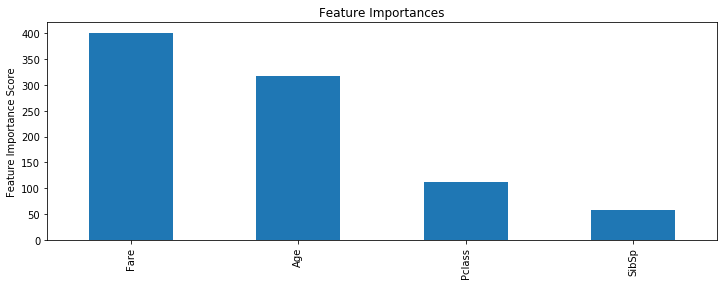

In [134]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.55,
 reg_alpha = 1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test)


Model Report
Accuracy (Train): 0.7907
AUC Score (Train): 0.874601
Accuracy (Test): 0.7709
AUC Score (Test): 0.808880


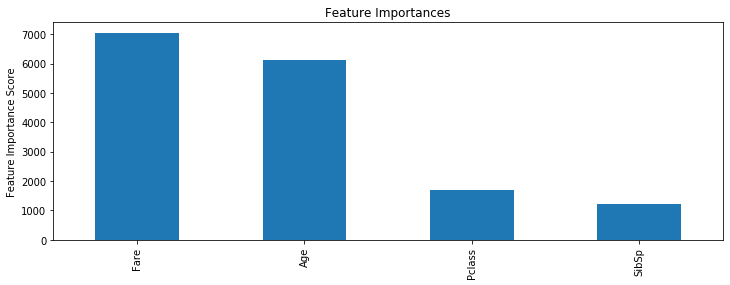

In [138]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.55,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test, early_stopping_rounds=500)

## Multi-class метрики

In [42]:
# https://stackoverflow.com/questions/9004172/precision-recall-for-multiclass-multilabel-classification
# https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
# https://scikit-learn.org/stable/modules/multiclass.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification

In [21]:
from sklearn import metrics
import numpy as np

In [37]:
y_true = np.array([0, 1, 2, 0, 1, 2, 2, 2, 3])
y_pred = np.array([0, 2, 1, 0, 0, 1, 3, 3, 3])

In [50]:
# micro 
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(4):
    TP += ((y_true == i) * (y_pred == i)).sum()
    FP += ((y_true != i) * (y_pred == i)).sum()
    TN += ((y_true != i) * (y_pred != i)).sum()
    FN += ((y_true == i) * (y_pred != i)).sum()

micro_P, micro_R = TP/(TP+FP), TP/(TP+FN)
micro_P, micro_R

(0.3333333333333333, 0.3333333333333333)

In [60]:
# macro 
macro_P, macro_R = 0, 0

for i in range(4):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    TP += ((y_true == i) * (y_pred == i)).sum()
    FP += ((y_true != i) * (y_pred == i)).sum()
    TN += ((y_true != i) * (y_pred != i)).sum()
    FN += ((y_true == i) * (y_pred != i)).sum()

    macro_P += TP/(TP+FP)
    macro_R += TP/(TP+FN)
    
macro_P /= 4
macro_R /= 4

macro_P, macro_R

(0.25, 0.5)

In [52]:
metrics.precision_score(y_true, y_pred, average='micro')

0.3333333333333333

In [53]:
metrics.recall_score(y_true, y_pred, average='micro')

0.3333333333333333

In [54]:
metrics.precision_score(y_true, y_pred, average='macro')

0.25

In [55]:
metrics.recall_score(y_true, y_pred, average='macro')

0.5